https://fdasrsf-python.readthedocs.io/en/latest/time_warping.html

In [1]:
from fdasrsf.time_warping import align_fPCA

In [2]:
import numpy as np

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv("../flare_tables/20200227_vetted_flares_lacking_some.csv")
df = df[df.real == 1] 
df = df[df.complex == 0]
df = df[df.ampl_rec > .05]
#df = df[df.ampl_rec .< 1., :]
df = df[(df.cstop-df.cstart) < 39]
df = df[(df.cstop-df.cstart) > 5]

df = df.iloc[:4]
n = df.shape[0]
n

4

In [5]:
a = np.ones((n, 96));

for i in range(n):
    l = df[["TIC","sector","cstart"]].iloc[i]
    s =f"{str(l.TIC).zfill(16)}_{l.sector}_{l.cstart}.csv"
    f = pd.read_csv(f"../flare_snippets/{s}")
    a[i,:len(f.f)] =  f.f



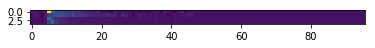

In [6]:
plt.imshow(a)

Initializing...
Aligning 4 functions in SRVF space to 3 fPCA components...
updating step: r=1
updating step: r=2
updating step: r=3


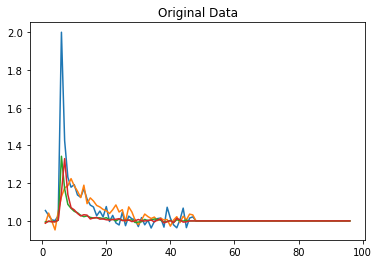

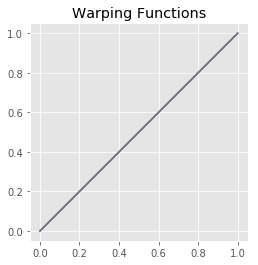

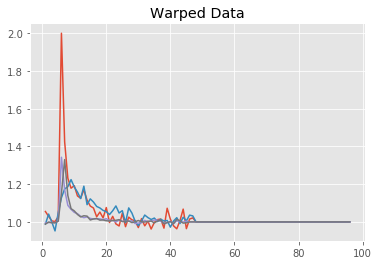

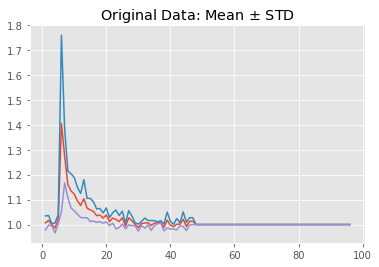

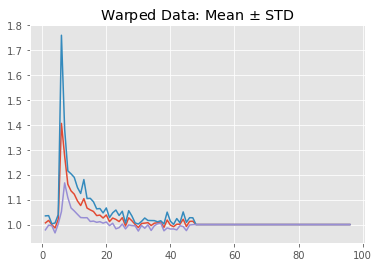

/home/ekaterina/Documents/001_Science/Flares_in_Clusters_II/flaresinclustersii/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


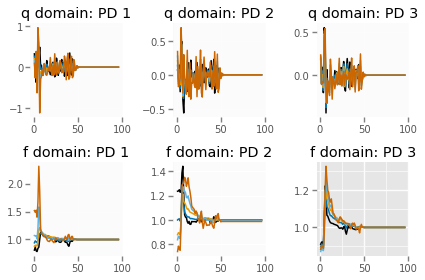

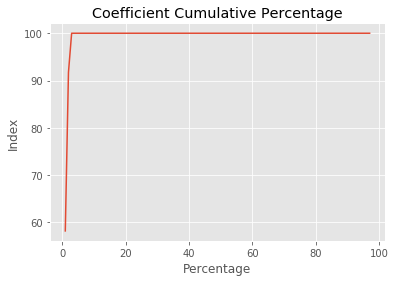

((96, 4), (96,))

In [7]:
align_fPCA(a.T, np.arange(1,97).astype(float))
a.T.shape, np.arange(1,97).shape

In [8]:
np.arange(1,97).dtype

dtype('int64')